# Planar data classification with one hidden layer

Welcome to your week 3 programming assignment! It's time to build your first neural network, which will have one hidden layer. Now, you'll notice a big difference between this model and the one you implemented previously using logistic regression.

By the end of this assignment, you'll be able to:

- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh
- Compute the cross entropy loss
- Implement forward and backward propagation


## Table of Contents
- [1 - Packages](#1)
- [2 - Load the Dataset](#2)
    - [Exercise 1](#ex-1)
- [3 - Simple Logistic Regression](#3)
- [4 - Neural Network model](#4)
    - [4.1 - Defining the neural network structure](#4-1)
        - [Exercise 2 - layer_sizes](#ex-2)
    - [4.2 - Initialize the model's parameters](#4-2)
        - [Exercise 3 - initialize_parameters](#ex-3)
    - [4.3 - The Loop](#4-3)
        - [Exercise 4 - forward_propagation](#ex-4)
    - [4.4 - Compute the Cost](#4-4)
        - [Exercise 5 - compute_cost](#ex-5)
    - [4.5 - Implement Backpropagation](#4-5)
        - [Exercise 6 - backward_propagation](#ex-6)
    - [4.6 - Update Parameters](#4-6)
        - [Exercise 7 - update_parameters](#ex-7)
    - [4.7 - Integration](#4-7)
        - [Exercise 8 - nn_model](#ex-8)
- [5 - Test the Model](#5)
    - [5.1 - Predict](#5-1)
        - [Exercise 9 - predict](#ex-9)
    - [5.2 - Test the Model on the Planar Dataset](#5-2)
- [6 - Tuning hidden layer size (optional/ungraded exercise)](#6)
- [7- Performance on other datasets](#7)

<a name='1'></a>
# 1 - Packages

First import all the packages that you will need during this assignment.

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [45]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
from public_tests import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(2) # set a seed so that the results are consistent

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
# 2 - Load the Dataset 

Now, load the dataset you'll be working on. The following code will load a "flower" 2-class dataset into variables X and Y.

In [2]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

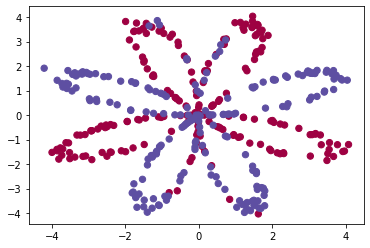

In [3]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

First, get a better sense of what your data is like. 

<a name='ex-1'></a>
### Exercise 1 

How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

**Hint**: How do you get the shape of a numpy array? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [47]:
# (≈ 3 lines of code)
# shape_X = ...
# shape_Y = ...
# training set size
# m = ...
# YOUR CODE STARTS HERE
shape_X = np.shape(X)
shape_Y = np.shape(Y)
m = X.shape[1]
# YOUR CODE ENDS HERE

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 200)
The shape of Y is: (1, 200)
I have m = 200 training examples!


**Expected Output**:
       
<table style="width:20%">
  <tr>
    <td> shape of X </td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td>shape of Y</td>
    <td>(1, 400) </td> 
    </tr>
    <tr>
    <td>m</td>
    <td> 400 </td> 
  </tr>
</table>

<a name='3'></a>
## 3 - Simple Logistic Regression

Before building a full neural network, let's check how logistic regression performs on this problem. You can use sklearn's built-in functions for this. Run the code below to train a logistic regression classifier on the dataset.

In [48]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

You can now plot the decision boundary of these models! Run the code below.

Accuracy of logistic regression: 86 % (percentage of correctly labelled datapoints)


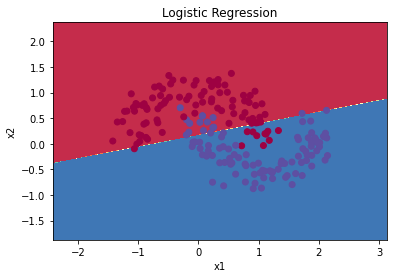

In [49]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:

<table style="width:20%">
  <tr>
    <td>Accuracy</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

<a name='4'></a>
## 4 - Neural Network model

Logistic regression didn't work well on the flower dataset. Next, you're going to train a Neural Network with a single hidden layer and see how that handles the same problem.

**The model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

In practice, you'll often build helper functions to compute steps 1-3, then merge them into one function called `nn_model()`. Once you've built `nn_model()` and learned the right parameters, you can make predictions on new data.

<a name='4-1'></a>
### 4.1 - Defining the neural network structure ####

<a name='ex-2'></a>
### Exercise 2 - layer_sizes 

Define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [50]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    #(≈ 3 lines of code)
    # n_x = ... 
    # n_h = ...
    # n_y = ... 
    # YOUR CODE STARTS HERE
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    # YOUR CODE ENDS HERE
    return (n_x, n_h, n_y)

In [51]:
t_X, t_Y = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(t_X, t_Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

layer_sizes_test(layer_sizes)

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2
 All tests passed.


***Expected output***
```
The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2
```

<a name='4-2'></a>
### 4.2 - Initialize the model's parameters ####

<a name='ex-3'></a>
### Exercise 3 -  initialize_parameters

Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [52]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [53]:
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

initialize_parameters_test(initialize_parameters)

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
 All tests passed.


**Expected output**
```
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
```

<a name='4-3'></a>
### 4.3 - The Loop 

<a name='ex-4'></a>
### Exercise 4 - forward_propagation

Implement `forward_propagation()` using the following equations:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$


**Instructions**:

- Check the mathematical representation of your classifier in the figure above.
- Use the function `sigmoid()`. It's built into (imported) this notebook.
- Use the function `np.tanh()`. It's part of the numpy library.
- Implement using these steps:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()` by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "cache". The cache will be given as an input to the backpropagation function.

In [54]:
# GRADED FUNCTION:forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # YOUR CODE ENDS HERE
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    # (≈ 4 lines of code)
    # Z1 = ...
    # A1 = ...
    # Z2 = ...
    # A2 = ...
    # YOUR CODE STARTS HERE
    Z1 = (np.dot(W1,X) + b1)
    A1 = np.tanh(Z1)
    Z2 = (np.dot(W2,A1)+ b2) 
    A2 = sigmoid(Z2)
    
    # YOUR CODE ENDS HERE
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [55]:
t_X, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(t_X, parameters)
print("A2 = " + str(A2))

forward_propagation_test(forward_propagation)

A2 = [[0.21292656 0.21274673 0.21295976]]
 All tests passed.


***Expected output***
```
A2 = [[0.21292656 0.21274673 0.21295976]]
```

<a name='4-4'></a>
### 4.4 - Compute the Cost

Now that you've computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for all examples, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

<a name='ex-5'></a>
### Exercise 5 - compute_cost 

Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. This is one way to implement one part of the equation without for loops:
$- \sum\limits_{i=1}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)          
```

- Use that to build the whole expression of the cost function.

**Notes**: 

- You can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).  
- If you use `np.multiply` followed by `np.sum` the end result will be a type `float`, whereas if you use `np.dot`, the result will be a 2D numpy array.  
- You can use `np.squeeze()` to remove redundant dimensions (in the case of single float, this will be reduced to a zero-dimension array). 
- You can also cast the array as a type `float` using `float()`.

In [56]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    # (≈ 2 lines of code)
    # logprobs = ...
    # cost = ...
    # YOUR CODE STARTS HERE
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),(1-Y))
    cost = - np.sum(logprobs) * 1/m 
    
    # YOUR CODE ENDS HERE
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

In [57]:
A2, t_Y = compute_cost_test_case()
cost = compute_cost(A2, t_Y)
print("cost = " + str(compute_cost(A2, t_Y)))

compute_cost_test(compute_cost)

cost = 0.6930587610394646
 All tests passed.


***Expected output***

`cost = 0.6930587610394646`


<a name='4-5'></a>
### 4.5 - Implement Backpropagation

Using the cache computed during forward propagation, you can now implement backward propagation.

<a name='ex-6'></a>
### Exercise 6 -  backward_propagation

Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Backpropagation. Use the six equations on the right.</font></center></caption>

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [58]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    #(≈ 2 lines of code)
    # W1 = ...
    # W2 = ...
    # YOUR CODE STARTS HERE
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    # YOUR CODE ENDS HERE
        
    # Retrieve also A1 and A2 from dictionary "cache".
    #(≈ 2 lines of code)
    # A1 = ...
    # A2 = ...
    # YOUR CODE STARTS HERE
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # YOUR CODE ENDS HERE
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    #(≈ 6 lines of code, corresponding to 6 equations on slide above)
    # dZ2 = ...
    # dW2 = ...
    # db2 = ...
    # dZ1 = ...
    # dW1 = ...
    # db1 = ...
    # YOUR CODE STARTS HERE
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2,A1.T)
    db2 = 1/m * np.sum(dZ2 ,axis=1 , keepdims=True)
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2)) 
    dW1 = 1/m * np.dot(dZ1,X.T)
    db1 = 1/m * np.sum(dZ1 ,axis=1 , keepdims=True)
    
    # YOUR CODE ENDS HERE
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [59]:
parameters, cache, t_X, t_Y = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, t_X, t_Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

backward_propagation_test(backward_propagation)

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]
 All tests passed.


***Expected output***
```
dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]
```

<a name='4-6'></a>
### 4.6 - Update Parameters 

<a name='ex-7'></a>
### Exercise 7 - update_parameters

Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">
<caption><center><font color='purple'><b>Figure 2</b>: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.</font></center></caption>



In [60]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # YOUR CODE ENDS HERE
    
    # Retrieve each gradient from the dictionary "grads"
    #(≈ 4 lines of code)
    # dW1 = ...
    # db1 = ...
    # dW2 = ...
    # db2 = ...
    # YOUR CODE STARTS HERE
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # YOUR CODE ENDS HERE
    
    # Update rule for each parameter
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    # YOUR CODE ENDS HERE
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [61]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

update_parameters_test(update_parameters)

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
 All tests passed.


***Expected output***
```
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
```

<a name='4-7'></a>
### 4.7 - Integration

Integrate your functions in `nn_model()` 

<a name='ex-8'></a>
### Exercise 8 - nn_model

Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [62]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        #(≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        # A2, cache = ...
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        # cost = ...
        cost = compute_cost(A2, Y)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        # grads = ...
        grads = backward_propagation(parameters, cache, X, Y)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        # parameters = ...
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [63]:
t_X, t_Y = nn_model_test_case()
parameters = nn_model(t_X, t_Y, 4, num_iterations=10000, print_cost=True)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

nn_model_test(nn_model)

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]
 All tests passed.


***Expected output***
```
Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
...
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]
```

<a name='5'></a>
## 5 - Test the Model

<a name='5-1'></a>
### 5.1 - Predict

<a name='ex-9'></a>
### Exercise 9 - predict

Predict with your model by building `predict()`.
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [64]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    #(≈ 2 lines of code)
    # A2, cache = ...
    # predictions = ...
    # YOUR CODE STARTS HERE
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    # YOUR CODE ENDS HERE
    
    return predictions

In [65]:
parameters, t_X = predict_test_case()

predictions = predict(parameters, t_X)
print("Predictions: " + str(predictions))

predict_test(predict)

Predictions: [[ True False  True]]
 All tests passed.


***Expected output***
```
Predictions: [[ True False  True]]
```

<a name='5-2'></a>
### 5.2 - Test the Model on the Planar Dataset

It's time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units!

Cost after iteration 0: 0.692985
Cost after iteration 1000: 0.048365
Cost after iteration 2000: 0.032428
Cost after iteration 3000: 0.026280
Cost after iteration 4000: 0.022673
Cost after iteration 5000: 0.020320
Cost after iteration 6000: 0.018691
Cost after iteration 7000: 0.017518
Cost after iteration 8000: 0.016641
Cost after iteration 9000: 0.015959


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

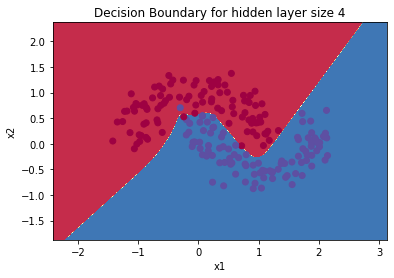

In [66]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [67]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 99%


**Expected Output**: 

<table style="width:30%">
  <tr>
    <td><b>Accuracy</b></td>
    <td> 90% </td> 
  </tr>
</table>

Accuracy is really high compared to Logistic Regression. The model has learned the patterns of the flower's petals! Unlike logistic regression, neural networks are able to learn even highly non-linear decision boundaries. 

### Congrats on finishing this Programming Assignment! 

Here's a quick recap of all you just accomplished: 

- Built a complete 2-class classification neural network with a hidden layer
- Made good use of a non-linear unit
- Computed the cross entropy loss
- Implemented forward and backward propagation
- Seen the impact of varying the hidden layer size, including overfitting.

You've created a neural network that can learn patterns! Excellent work. Below, there are some optional exercises to try out some other hidden layer sizes, and other datasets. 

<a name='6'></a>
## 6 - Tuning hidden layer size (optional/ungraded exercise)

Run the following code(it may take 1-2 minutes). Then, observe different behaviors of the model for various hidden layer sizes.

In [ ]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 1 hidden units: 86.0 %
Accuracy for 2 hidden units: 85.5 %
Accuracy for 3 hidden units: 99.0 %
Accuracy for 4 hidden units: 99.5 %
Accuracy for 5 hidden units: 99.5 %
Accuracy for 20 hidden units: 99.0 %


**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticeable overfitting.
- Later, you'll become familiar with regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

**Note**: Remember to submit the assignment by clicking the blue "Submit Assignment" button at the upper-right. 

**Some optional/ungraded questions that you can explore if you wish**: 
- What happens when you change the tanh activation for a sigmoid activation or a ReLU activation?
- Play with the learning_rate. What happens?
- What if we change the dataset? (See part 5 below!)

<a name='7'></a>
## 7- Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

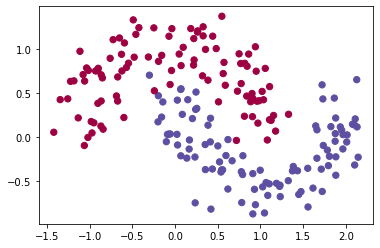

In [46]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

**References**:

- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/